# Import Libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pdb

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.externals.six import StringIO
from sklearn.externals import joblib
from IPython.core.display import Image, display
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set(style="ticks")

ImportError: No module named 'seaborn'

# EDA

In [2]:
# load data
train_df = pd.read_csv('train.csv')

# check for missing values in frame. 
print("Is any null value in this data:", train_df.isnull().values.any())
print("Raw training set shape:", train_df.shape)

predictors = list(train_df) # includes ID and target/class columns
train_id = predictors.pop(0) # pop out ID column
target = list.pop(predictors) # pop out target column
print(predictors)

### We intend to verify that the binary features are mutually exclusive (wilderness and soils features). 
soils_only_df = train_df[train_df.columns[15:-1]] # extract columns of soil types. leave out the class column.
sums = soils_only_df.sum(axis=1) # total each row. 
for i in range(sums.shape[0]):
    if sums.iloc[i] != 1:
        print("Not mutually exclusive or no soil type in this sample:", i)
wilderness_only_df = train_df[train_df.columns[11:15]] # extract columns of wilderness types
sums = wilderness_only_df.sum(axis=1) # total each row. 
for i in range(sums.shape[0]):
    if sums.iloc[i] != 1:
        print("Not mutually exclusive or no wilderness type in this sample:", i)

# Now, combine all soil columns into a single soil multifactor column. Ditto for Wilderness_Area* 
# Caveat: The train data's ID starts from 1, while panda's index starts from 0. 
# Don't forget to tag on the class column. 

### make a function out of this as well. will need it to transform actual test data. 
train_mod_df = train_df.iloc[:,:11].copy() # grab all rows from 0 thru 10. 
train_mod_df['WILDERNESS']=0 # Replaces Wilderness_Area* features. 
train_mod_df['SOILS']=0 # Replaces Soil_Type* features. 

for index, row in train_df.iterrows():
    for j in range(15,row.shape[0]-1): # make sure you don't grab the class column
        if row.iloc[j] == 1.0:
            train_mod_df.loc[index,'SOILS'] = j-14 # values start from 1

for index, row in train_df.iterrows():
    for j in range(11,15): # make sure you don't grab the class column
        if row.iloc[j] == 1.0:
            train_mod_df.loc[index,'WILDERNESS'] = j-10 # values start from 1

train_mod_df[target] = train_df[target] # Add back the Class column

Is any null value in this data: False
Raw training set shape: (15120, 56)
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']


In [3]:
# Rename dataframe for consistency
train_df = train_mod_df
train_df.shape

(15120, 14)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'WILDERNESS', 'SOILS']


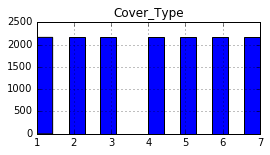

C:\Users\Jessica\Anaconda3\lib\site-packages\pandas\core\frame.py:2378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


After split, Train and Dev dataset shapes are: (12096, 14) (3024, 14)


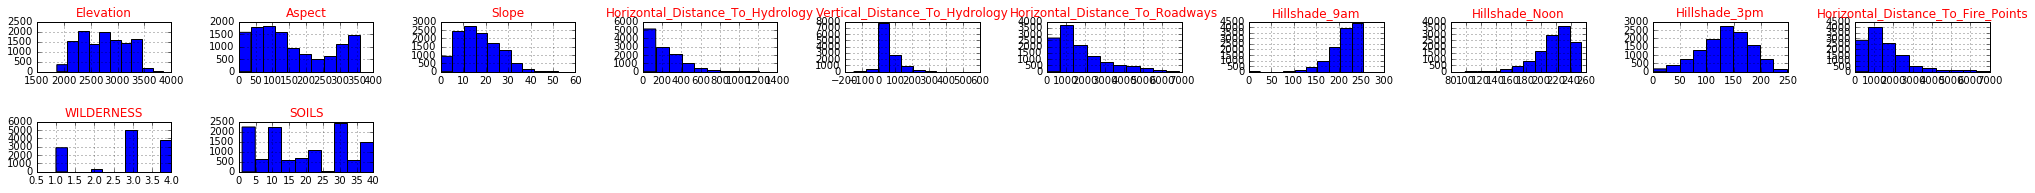

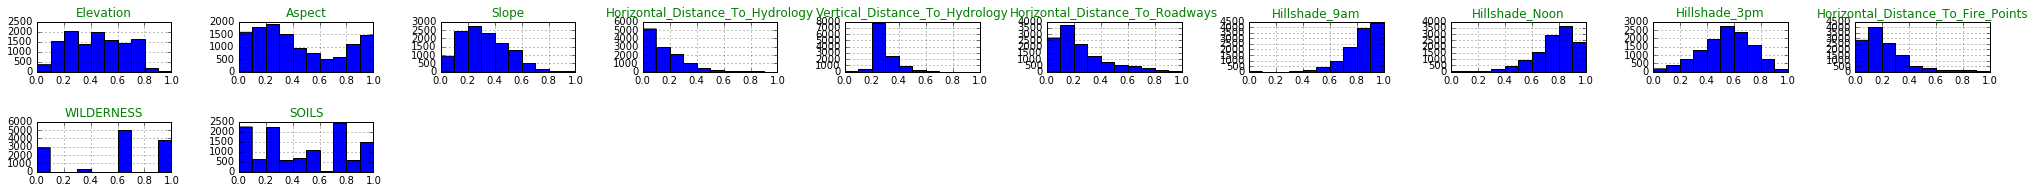

In [4]:
# Get predictors out again
predictors = list(train_df) # includes ID and target/class columns
train_id = predictors.pop(0) # pop out ID column
target = list.pop(predictors) # pop out target column
print(predictors)

# two kinds of normalization - min-max or z-score. z-score may lead to negative values for otherwise non-negative quantities 
# (such as altitude) - which may be ok from a prediction standpoint 

# Need to store these values for normalizing new data presented to the eventual model for prediction. 
train_df_mean =  train_df.mean().astype(float)
train_df_sd = train_df.std().astype(float)
train_df_min = train_df.min().astype(float)
train_df_max = train_df.max().astype(float)

# plot cover type histogram, check to see if any stratification is required for train,dev split. 
plt.figure(figsize=(4, 2))
ax = train_df['Cover_Type'].hist(bins=14)
ax.set_title('Cover_Type')
plt.show()
train_df, dev_df = train_test_split(train_df,test_size=0.2)

### plot histograms before and after min-max normalization
# display histograms for basic EDA. titles in Red. 
plt.figure(figsize=(35, 35))
plt.subplots_adjust(hspace=1.0,wspace=0.5)
for i in range(0,len(predictors)):
    plt.subplot(20,10,i+1)
    data = train_df[predictors[i]].T # transposing to view counts on y-axis
    ax = data.hist()
    #ax.axis([train_df_min[predictors][i], train_df_max[predictors][i], 0, 4000])
    ax.set_title(predictors[i],color='Red')

# going with min-max. tries z-scores before, but now doubt it will work well for SOIL and WILDERNESS
train_df[predictors] = (train_df[predictors]-train_df_min[predictors])/(train_df_max[predictors]-train_df_min[predictors])
dev_df[predictors] = (dev_df[predictors]-train_df_min[predictors])/(train_df_max[predictors]-train_df_min[predictors])

print("After split, Train and Dev dataset shapes are:",train_df.shape, dev_df.shape)

# display histograms post normalization. Titles in Green.
plt.figure(figsize=(35, 35))
plt.subplots_adjust(hspace=1.0,wspace=0.5)
for i in range(0,len(predictors)):
    plt.subplot(20,10,i+1)
    data = train_df[predictors[i]].T # transposing to view counts on y-axis
    aax = data.hist()
    aax.set_title(predictors[i],color='Green') 
    
#spm = pd.plotting.scatter_matrix(train_df[predictors[0:10]], alpha=0.5, figsize=(15,15), diagonal='hist')
#sns.pairplot(train_df[predictors[10:]])

# Base Model

In [5]:
# defining best parameters for knn 
# (we searched other values of k but for the sake of runtime have now limited the list)
tuned_parameters = [{'n_neighbors': [1, 2, 3, 4, 5],
'weights': ['distance', 'uniform'],
'algorithm': ['ball_tree', 'kd_tree', 'brute']}]
scores = ['precision_weighted', 'recall_weighted']
performances = [];
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=10, scoring=score)
    clf.fit(train_df[predictors], train_df[target])
    print("Best parameters set found on training data:")
    print('\n', clf.best_estimator_, '\n')

# Tuning hyper-parameters for precision_weighted



KeyboardInterrupt: 

In [6]:
# our base model is knn we will attempt to improve our accuracy score from here

knn = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', leaf_size=30)
knn.fit(train_df[predictors], train_df[target])
dev_pred = knn.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.74      0.70      0.72       437
          2       0.73      0.64      0.68       472
          3       0.80      0.72      0.76       429
          4       0.90      0.94      0.92       446
          5       0.82      0.94      0.87       403
          6       0.78      0.81      0.79       432
          7       0.92      0.98      0.95       405

avg / total       0.81      0.81      0.81      3024



# Weak Models

In [7]:
# naive bayes not a good result

#instantiate and binarize data
clf = BernoulliNB(binarize=0.5)
#fit model
mod = clf.fit(train_df[predictors],train_df[target])
#predict on dev
dev_pred = mod.predict(dev_df[predictors])
#accuracy score
print ("NB binarized accuracy:", accuracy_score(dev_df[target],dev_pred))

#instantiate and binarize data
clf = GaussianNB()
#fit model
mod = clf.fit(train_df[predictors],train_df[target])
#predict on dev
dev_pred = mod.predict(dev_df[predictors])
#accuracy score
print ("NB Gaussian accuracy:", accuracy_score(dev_df[target],dev_pred))

NB binarized accuracy: 0.420634920635
NB Gaussian accuracy: 0.585648148148


In [20]:
# Attempt linear support vector classifier, weak results

lsvc = LinearSVC(C=1)
lsvc.fit(train_df[predictors],train_df[target])
dev_pred = lsvc.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.57      0.43      0.49       437
          2       0.52      0.40      0.46       472
          3       0.55      0.49      0.52       429
          4       0.75      0.92      0.82       446
          5       0.54      0.53      0.53       403
          6       0.50      0.55      0.53       432
          7       0.70      0.91      0.79       405

avg / total       0.59      0.60      0.59      3024



In [29]:
# Attempt softmax regression, weak results

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs",C=4)
softmax_reg.fit(train_df[predictors], train_df[target])
dev_pred = softmax_reg.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.64      0.62      0.63       408
          2       0.57      0.47      0.52       440
          3       0.57      0.46      0.51       443
          4       0.75      0.86      0.80       447
          5       0.62      0.69      0.65       419
          6       0.55      0.62      0.58       407
          7       0.85      0.88      0.87       460

avg / total       0.65      0.66      0.65      3024



# Random Forest

## Tree bagging method (simplified random forest): repeat random sampling in the data to run Decision Tree, then use the majority vote classification for all predictions to make a final prediction.

### The result of 10 bootstrap iterations shows an improved accuracy from ~0.75(single decision tree) to 0.83

In [43]:
np.random.seed(500)

def sample_index(n):
    bootstrap_sample_index = np.random.choice(range(n), size=n, replace=True)
    return bootstrap_sample_index

# Tree bagging with 10 bootstrap iterations
fc_tree_preds = np.empty((0,dev_df[target].shape[0]))
B = 10
for i in range(B):
    bootstrap_sample_index = sample_index(train_df[predictors].shape[0])
    fc_data = train_df[predictors].iloc[bootstrap_sample_index]
    fc_labels = train_df[target].iloc[bootstrap_sample_index]
    fc_tree = DecisionTreeClassifier(criterion="entropy", splitter="best")
    fc_tree.fit(fc_data, fc_labels)
    print(fc_tree.score(dev_df[predictors], dev_df[target]))
    fc_tree_preds = np.vstack((fc_tree_preds, fc_tree.predict(dev_df[predictors])))

# Use the majority vote classification for the predictions above
fc_tree_preds_transpose = fc_tree_preds.transpose().astype('int')
print(fc_tree_preds_transpose.shape)
# Find the label with the max count out of B times for each data
c = np.zeros(fc_tree_preds_transpose.shape[0])
for i in range(dev_df[target].shape[0]):
    c[i] = np.bincount(fc_tree_preds_transpose[i]).argmax()
# The accuracy of tree bagging method
print('accuracy of tree bagging with 10 bootstrap iterations', np.mean(c==dev_df[target]))

0.750992063492
0.766534391534
0.75958994709
0.759259259259
0.763558201058
0.76421957672
0.761904761905
0.755291005291
0.750661375661
0.75496031746
(3024, 10)
accuracy of tree bagging with 10 bootstrap iterations 0.83630952381


## Sklearn Random Forest

In [21]:
# Next, evaluate a Random Forest with 500 trees. This represents and improvement

rf = RandomForestClassifier(n_estimators=500, oob_score=True, criterion="entropy")
scores = cross_val_score(rf, train_df[predictors], train_df[target], cv=10)
print ("Mean R^2 = {:.3}".format(scores.mean()))

Mean R^2 = 0.863


In [14]:
# Evaluate accuracy on dev data

rf.fit(train_df[predictors], train_df[target])
print(rf.score(dev_df[predictors], dev_df[target]))
dev_pred = rf.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

0.864748677249
             precision    recall  f1-score   support

          1       0.82      0.76      0.79       408
          2       0.81      0.72      0.76       440
          3       0.85      0.79      0.82       443
          4       0.92      0.98      0.95       447
          5       0.88      0.94      0.91       419
          6       0.82      0.87      0.85       407
          7       0.94      0.98      0.96       460

avg / total       0.86      0.86      0.86      3024



In [15]:
# Optimize parameters using GridSearch

param_grid = [
    {'n_estimators': [100, 250, 500, 750], 'max_features': [2, 4, 6, 8, 'auto'], 'oob_score':[True,False]},
    {'bootstrap': [False], 'n_estimators': [250, 500], 'max_features': [2, 4, 6, 8, 'auto'], 'min_samples_leaf': [1,5,10,50,100,200,500]},
  ]
rf = RandomForestClassifier()

start_time = time.time()
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(train_df[predictors], train_df[target])
end_time = time.time()
print("Wallclock time in secs for Random Forest Grid Search:",end_time - start_time)
print("Best params from grid search are:",grid_search.best_params_)

Wallclock time in secs for Random Forest Grid Search: 8208.442597150803
Best params from grid search are: {'bootstrap': False, 'max_features': 4, 'min_samples_leaf': 1, 'n_estimators': 500}


In [22]:
# Rerun random forest with best parameters obtained by Gridsearch

rf = RandomForestClassifier(bootstrap=False, max_features=4, n_estimators=500)
rf.fit(train_df[predictors],train_df[target])
print(rf.score(dev_df[predictors], dev_df[target]))
dev_pred = rf.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))
joblib.dump(rf, "rf.pkl")

0.867724867725
             precision    recall  f1-score   support

          1       0.77      0.79      0.78       437
          2       0.80      0.69      0.74       472
          3       0.87      0.84      0.86       429
          4       0.94      0.97      0.95       446
          5       0.89      0.95      0.92       403
          6       0.87      0.88      0.87       432
          7       0.95      0.97      0.96       405

avg / total       0.87      0.87      0.87      3024



['rf.pkl']

In [17]:
# Optimize random forest with random gridsearch

param_grid = {'n_estimators': [100,250,500,750],'max_features': [2, 4, 6, 8, 'log2'] }
rf = RandomForestClassifier(oob_score=True)

start_time = time.time()
random_search = RandomizedSearchCV(rf,param_distributions=param_grid, n_iter=20)
random_search.fit(train_df[predictors],train_df[target])
end_time = time.time()
print("Wallclock time in secs for Random Forest Grid Search:",end_time - start_time)
print("Randomized grid search best params are:",random_search.best_params_)

Wallclock time in secs for Random Forest Grid Search: 518.9294080734253
Randomized grid search best params are: {'n_estimators': 250, 'max_features': 4}


In [18]:
# Rerun random forest with best parameters obtained by random gridsearch

random_rf = RandomForestClassifier(n_estimators=250, max_features=4)
random_rf.fit(train_df[predictors],train_df[target])
print(random_rf.score(dev_df[predictors], dev_df[target]))
dev_pred = random_rf.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))
joblib.dump(random_rf, "random_rf.pkl")

0.861441798942
             precision    recall  f1-score   support

          1       0.81      0.75      0.78       408
          2       0.79      0.71      0.75       440
          3       0.84      0.81      0.82       443
          4       0.92      0.97      0.95       447
          5       0.88      0.94      0.91       419
          6       0.83      0.87      0.85       407
          7       0.94      0.97      0.95       460

avg / total       0.86      0.86      0.86      3024



['random_rf.pkl']

# Voting Classifier

In [42]:
# Run Voting Classifier

voter = VotingClassifier(
    estimators=[('rf', rf),('lr', softmax_reg),('rrf', random_rf), ('knn', knn)],
    voting='hard')
voter.fit(train_df[predictors], train_df[target])
dev_pred = voter.predict(dev_df[predictors])
print(classification_report(dev_df[target],dev_pred))

/Users/heatherfeinstein/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/heatherfeinstein/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


             precision    recall  f1-score   support

          1       0.76      0.80      0.78       408
          2       0.80      0.65      0.72       440
          3       0.81      0.82      0.81       443
          4       0.90      0.97      0.94       447
          5       0.88      0.92      0.90       419
          6       0.83      0.81      0.82       407
          7       0.94      0.97      0.95       460

avg / total       0.85      0.85      0.85      3024



In [ ]:
# Generalized voter (takes hours to run. will experiment next week)

n_estimators_start = 100
n_estimators_end = 2501 # May take a while. 
n_estimators = [i for i in range(n_estimators_start,n_estimators_end)]
voter_models = [(str(k),RandomForestClassifier(n_estimators = k, max_features='auto', oob_score=True)) for k in n_estimators]
voter_models.append(('rrf', random_rf)) # append any tuples here. 
voter = VotingClassifier(
    estimators= voter_models,
    voting='soft')
start_time = time.time()
voter.fit(train_df[predictors], train_df[target])
dev_pred = voter.predict(dev_df[predictors])
end_time = time.time()
print(classification_report(dev_df[target],dev_pred))
print(voter.score(dev_df[predictors], dev_df[target]))
print("Wallclock time in secs for Voter:",end_time - start_time)
#print("Voter params: ", voter.get_params(deep=False)) # unfortunately, unable to extract winning candidate. 

# PCA

Variance explained by first 1 principal components: 0.435
Variance explained by first 2 principal components: 0.655
Variance explained by first 3 principal components: 0.751
Variance explained by first 4 principal components: 0.825
Variance explained by first 5 principal components: 0.874
Variance explained by first 6 principal components: 0.914
Variance explained by first 7 principal components: 0.945
Variance explained by first 8 principal components: 0.969
Variance explained by first 9 principal components: 0.984
Variance explained by first 10 principal components: 0.995
Variance explained by first 11 principal components: 1.0
Variance explained by first 12 principal components: 1.0


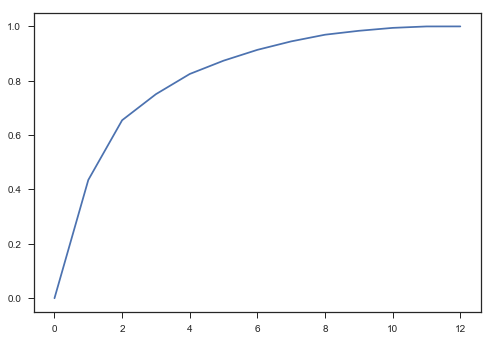

In [32]:
#PCA - find explained variance from each PC to determine an appropriate # of dimensions

from sklearn.decomposition import PCA

pca_mod = PCA(n_components=train_df.shape[1]-2)
pca_mod.fit(train_df[predictors])
explained_var = 0
exp_vars = [explained_var]

for k in range(0,train_df.shape[1]-2):
    explained_var += pca_mod.explained_variance_ratio_[k]
    exp_vars.append(explained_var)
    print("Variance explained by first", k+1, "principal components:", round(explained_var,3))
    
plt.plot(exp_vars)

In [33]:
#Project data into n dimensions

n = 11
pca_mod = PCA(n_components = n)
projected_train = pca_mod.fit_transform(train_df[predictors])
projected_dev = pca_mod.transform(dev_df[predictors])

# Rerun Models with PCA

## KNN with PCA

In [34]:
knn = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', leaf_size=30)
knn.fit(projected_train, train_df[target])
dev_pred = knn.predict(projected_dev)
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.77      0.71      0.74       408
          2       0.71      0.65      0.68       440
          3       0.81      0.69      0.74       443
          4       0.88      0.94      0.91       447
          5       0.85      0.91      0.88       419
          6       0.73      0.81      0.77       407
          7       0.93      0.97      0.95       460

avg / total       0.81      0.81      0.81      3024



## Weaker Models with PCA - no meaningful improvement

In [35]:
# linear support vector classification w PCA

lsvc = LinearSVC(C=1)
lsvc.fit(projected_train,train_df[target])
dev_pred = lsvc.predict(projected_dev)
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.59      0.45      0.51       408
          2       0.53      0.43      0.47       440
          3       0.54      0.46      0.50       443
          4       0.74      0.91      0.81       447
          5       0.55      0.52      0.54       419
          6       0.49      0.60      0.54       407
          7       0.78      0.91      0.84       460

avg / total       0.61      0.62      0.61      3024



## Random Forest with PCA

In [36]:
# Optimize parameters for Random Forest with PCA with Gridsearch

param_grid = [
    {'n_estimators': [100, 250, 500, 750], 'max_features': [2, 4, 6, 8, 'auto'], 'oob_score':[True,False]},
    {'bootstrap': [False], 'n_estimators': [250, 500], 'max_features': [2, 4, 6, 8, 'auto']},
  ]
rf = RandomForestClassifier()

start_time = time.time()
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(projected_train, train_df[target])
end_time = time.time()
print("Wallclock time in secs for Random Forest Grid Search:",end_time - start_time)
print("Best params from grid search are:",grid_search.best_params_)

Wallclock time in secs for Random Forest Grid Search: 9633.682844161987
Best params from grid search are: {'bootstrap': False, 'max_features': 4, 'n_estimators': 500}


In [37]:
# Run Random Forest with PCA with parameters obtained through gridsearch

rf = RandomForestClassifier(bootstrap=False, max_features='auto', n_estimators=500)
rf.fit(projected_train,train_df[target])
print(rf.score(projected_dev, dev_df[target]))
dev_pred = rf.predict(projected_dev)
print(classification_report(dev_df[target],dev_pred))


0.838955026455
             precision    recall  f1-score   support

          1       0.78      0.75      0.77       408
          2       0.77      0.70      0.73       440
          3       0.83      0.77      0.80       443
          4       0.88      0.97      0.92       447
          5       0.87      0.91      0.89       419
          6       0.78      0.81      0.79       407
          7       0.94      0.96      0.95       460

avg / total       0.84      0.84      0.84      3024



In [38]:
# Optimize Random Forest with PCA through random Grid Search

param_grid = {'n_estimators': [100,250,500,750],'max_features': [2, 4, 6, 8, 'log2'] }
rf = RandomForestClassifier(oob_score=True)

start_time = time.time()
random_search = RandomizedSearchCV(rf,param_distributions=param_grid, n_iter=20)
random_search.fit(projected_train,train_df[target])
end_time = time.time()
print("Wallclock time in secs for Random Forest Grid Search:",end_time - start_time)
print("Randomized grid search best params are:",random_search.best_params_)

Wallclock time in secs for Random Forest Grid Search: 783.7757749557495
Randomized grid search best params are: {'n_estimators': 750, 'max_features': 2}


In [39]:
# Run random forest with PCA with parameters obtained through random gridsearch

random_rf = RandomForestClassifier(n_estimators=750, max_features='log2')
random_rf.fit(projected_train,train_df[target])
print(random_rf.score(projected_dev, dev_df[target]))
dev_pred = random_rf.predict(projected_dev)
print(classification_report(dev_df[target],dev_pred))

0.827380952381
             precision    recall  f1-score   support

          1       0.78      0.74      0.76       408
          2       0.75      0.68      0.71       440
          3       0.82      0.74      0.78       443
          4       0.87      0.97      0.92       447
          5       0.85      0.89      0.87       419
          6       0.76      0.80      0.78       407
          7       0.93      0.96      0.95       460

avg / total       0.83      0.83      0.83      3024



## Voting Classifier with PCA

In [40]:
# Run voting classifer with PCA

voter = VotingClassifier(
    estimators=[('rf', rf),('lr', softmax_reg),('rrf', random_rf), ('knn', knn)],
    voting='hard')
voter.fit(projected_train, train_df[target])
dev_pred = voter.predict(projected_dev)
print(classification_report(dev_df[target],dev_pred))

/Users/heatherfeinstein/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/heatherfeinstein/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


             precision    recall  f1-score   support

          1       0.73      0.78      0.76       408
          2       0.76      0.62      0.68       440
          3       0.79      0.76      0.77       443
          4       0.87      0.98      0.92       447
          5       0.85      0.89      0.87       419
          6       0.78      0.75      0.76       407
          7       0.94      0.94      0.94       460

avg / total       0.82      0.82      0.82      3024



## L1 Regularization

In [ ]:
## Use L1 Regularization (Logistic regression) to prune feature space

# set c values to test
C_vals = [0.02, 0.025, 0.05, 0.1]

#loop through all c values
for c in C_vals:
    # logistic regression with l1 regularization
    l1_model = LogisticRegression(C = c, penalty="l1")
    l1_model.fit(train_df[predictors], train_df[target])

    # determine which parameters are non-zero in any class
    sum_weights = np.array(l1_model.coef_[0] + l1_model.coef_[1] + l1_model.coef_[2] + l1_model.coef_[3]
                          + l1_model.coef_[4] + l1_model.coef_[5] + l1_model.coef_[6])
    pred_array = np.array(predictors)
    # new_pred is the list of non-zero parameters
    new_pred = pred_array[np.where(sum_weights != 0)]
    print("\nc-value:", c, "number parameters:", len(new_pred))
    print(new_pred) # too see which features are excluded

    
    
    rf_l1 = RandomForestClassifier(bootstrap=False, max_features=4, n_estimators=500)
#     scores = cross_val_score(rf_l1, train_df[new_pred], train_df[target], cv=10)
#     print ("Mean R^2 = {:.3}".format(scores.mean()))
    rf_l1.fit(train_df[new_pred], train_df[target])
    dev_pred = rf_l1.predict(dev_df[new_pred])
    print(classification_report(dev_df[target],dev_pred))

In [6]:
c = .025
l1_model = LogisticRegression(C = c, penalty="l1")
l1_model.fit(train_df[predictors], train_df[target])

# determine which parameters are non-zero in any class
sum_weights = np.array(l1_model.coef_[0] + l1_model.coef_[1] + l1_model.coef_[2] + l1_model.coef_[3]
                      + l1_model.coef_[4] + l1_model.coef_[5] + l1_model.coef_[6])
pred_array = np.array(predictors)
# new_pred is the list of non-zero parameters
new_pred = pred_array[np.where(sum_weights != 0)]
print("\nc-value:", c, "number parameters:", len(new_pred))
print(new_pred)


rf_l1 = RandomForestClassifier(bootstrap=False, max_features=4, n_estimators=500)
scores = cross_val_score(rf_l1, train_df[new_pred], train_df[target], cv=10)
print ("Mean R^2 = {:.3}".format(scores.mean()))
rf_l1.fit(train_df[new_pred], train_df[target])
dev_pred = rf_l1.predict(dev_df[new_pred])
print(classification_report(dev_df[target],dev_pred))


c-value: 0.025 number parameters: 10
['Elevation' 'Slope' 'Horizontal_Distance_To_Hydrology'
 'Horizontal_Distance_To_Roadways' 'Hillshade_9am' 'Hillshade_Noon'
 'Hillshade_3pm' 'Horizontal_Distance_To_Fire_Points' 'WILDERNESS' 'SOILS']
Mean R^2 = 0.872
             precision    recall  f1-score   support

          1       0.79      0.77      0.78       437
          2       0.79      0.71      0.75       440
          3       0.87      0.87      0.87       409
          4       0.95      0.97      0.96       418
          5       0.91      0.96      0.94       431
          6       0.87      0.88      0.87       416
          7       0.95      0.97      0.96       473

avg / total       0.88      0.88      0.88      3024



## KNN with L1 Reg

In [38]:
# defining best parameters for knn 
# (we searched other values of k but for the sake of runtime have now limited the list)
tuned_parameters = [{'n_neighbors': [1, 2, 3, 4, 5],
'weights': ['distance', 'uniform'],
'algorithm': ['ball_tree', 'kd_tree', 'brute']}]
scores = ['precision_weighted', 'recall_weighted']
performances = [];
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    clf = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=10, scoring=score)
    clf.fit(train_df[new_pred], train_df[target])
    print("Best parameters set found on training data:")
    print('\n', clf.best_estimator_, '\n')

# Tuning hyper-parameters for precision_weighted

Best parameters set found on training data:

 KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance') 

# Tuning hyper-parameters for recall_weighted

Best parameters set found on training data:

 KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='distance') 



In [7]:
## run knn model with best params -> improved!
knn_l1 = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree', leaf_size=30)
knn_l1.fit(train_df[new_pred], train_df[target])
dev_pred = knn_l1.predict(dev_df[new_pred])
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.75      0.74      0.74       437
          2       0.76      0.65      0.70       440
          3       0.83      0.74      0.78       409
          4       0.89      0.96      0.93       418
          5       0.83      0.94      0.88       431
          6       0.80      0.82      0.81       416
          7       0.93      0.96      0.95       473

avg / total       0.83      0.83      0.83      3024



## Weaker Models with L1 Reg

In [8]:
# naive bayes not a good result

#instantiate and binarize data
clf_l1 = BernoulliNB(binarize=0.5)
#fit model
mod_l1 = clf_l1.fit(train_df[new_pred],train_df[target])
#predict on dev
dev_pred = mod_l1.predict(dev_df[new_pred])
#accuracy score
print ("NB binarized accuracy:", accuracy_score(dev_df[target],dev_pred))

#instantiate and binarize data
clf = GaussianNB()
#fit model
mod = clf.fit(train_df[new_pred],train_df[target])
#predict on dev
dev_pred = mod.predict(dev_df[new_pred])
#accuracy score
print ("NB Gaussian accuracy:", accuracy_score(dev_df[target],dev_pred))

NB binarized accuracy: 0.429232804233
NB Gaussian accuracy: 0.596560846561


In [9]:
# linear support vector classification w L1 reg

lsvc_l1 = LinearSVC(C=1)
lsvc_l1.fit(train_df[new_pred],train_df[target])
dev_pred = lsvc_l1.predict(dev_df[new_pred])
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.56      0.43      0.49       437
          2       0.51      0.41      0.45       440
          3       0.49      0.47      0.48       409
          4       0.75      0.91      0.83       418
          5       0.55      0.48      0.51       431
          6       0.49      0.58      0.53       416
          7       0.74      0.90      0.81       473

avg / total       0.59      0.60      0.59      3024



In [10]:
# Attempt softmax regression with L1 reg

softmax_reg_l1 = LogisticRegression(multi_class="multinomial",solver="lbfgs",C=4)
softmax_reg_l1.fit(train_df[new_pred], train_df[target])
dev_pred = softmax_reg_l1.predict(dev_df[new_pred])
print(classification_report(dev_df[target],dev_pred))

             precision    recall  f1-score   support

          1       0.64      0.59      0.62       437
          2       0.58      0.46      0.51       440
          3       0.58      0.49      0.53       409
          4       0.78      0.86      0.81       418
          5       0.65      0.74      0.70       431
          6       0.56      0.62      0.59       416
          7       0.83      0.89      0.86       473

avg / total       0.66      0.67      0.66      3024



## Random Forests with L1 Reg

In [14]:
# Optimize parameters for Random Forest with L1 Reg with Gridsearch (takes a long time to run)

param_grid = [
    {'n_estimators': [100, 250, 500, 750], 'max_features': [2, 4, 6, 8, 'auto'], 'oob_score':[True,False]},
    {'bootstrap': [False], 'n_estimators': [250, 500], 'max_features': [2, 4, 6, 8, 'auto']},
  ]
rf_l1 = RandomForestClassifier()

start_time = time.time()
grid_search = GridSearchCV(rf_l1, param_grid, cv=5)
grid_search.fit(train_df[new_pred], train_df[target])
end_time = time.time()
print("Wallclock time in secs for Random Forest Grid Search:",end_time - start_time)
print("Best params from grid search are:",grid_search.best_params_)

Wallclock time in secs for Random Forest Grid Search: 2863.967574119568
Best params from grid search are: {'n_estimators': 250, 'bootstrap': False, 'max_features': 'auto'}


In [15]:
# Rerun random forest with best parameters obtained by Gridsearch

rf_l1 = RandomForestClassifier(bootstrap=False, max_features='auto', n_estimators=250)
rf_l1.fit(train_df[new_pred],train_df[target])
print(rf_l1.score(dev_df[new_pred], dev_df[target]))
dev_pred = rf_l1.predict(dev_df[new_pred])
print(classification_report(dev_df[target],dev_pred))

0.877976190476
             precision    recall  f1-score   support

          1       0.79      0.77      0.78       437
          2       0.79      0.71      0.75       440
          3       0.86      0.86      0.86       409
          4       0.95      0.98      0.96       418
          5       0.91      0.97      0.94       431
          6       0.87      0.89      0.88       416
          7       0.94      0.97      0.96       473

avg / total       0.88      0.88      0.88      3024



In [48]:
# Optimize random forest with random gridsearch (takes a long time to run)

param_grid = {'n_estimators': [100,250,500,750],'max_features': [2, 4, 6, 8, 'log2'] }
rf_temp = RandomForestClassifier(oob_score=True)

start_time = time.time()
random_search = RandomizedSearchCV(rf_temp,param_distributions=param_grid, n_iter=20)
random_search.fit(train_df[new_pred],train_df[target])
end_time = time.time()
print("Wallclock time in secs for Random Forest Grid Search:",end_time - start_time)
print("Randomized grid search best params are:",random_search.best_params_)

Wallclock time in secs for Random Forest Grid Search: 724.7622253894806
Randomized grid search best params are: {'max_features': 4, 'n_estimators': 500}


In [12]:
# Rerun random forest with best parameters obtained by random gridsearch

random_rf_l1 = RandomForestClassifier(n_estimators=500, max_features=4)
random_rf_l1.fit(train_df[new_pred],train_df[target])
print(random_rf_l1.score(dev_df[new_pred], dev_df[target]))
dev_pred = random_rf_l1.predict(dev_df[new_pred])
print(classification_report(dev_df[target],dev_pred))

0.867724867725
             precision    recall  f1-score   support

          1       0.77      0.75      0.76       437
          2       0.78      0.67      0.72       440
          3       0.86      0.85      0.85       409
          4       0.95      0.98      0.96       418
          5       0.89      0.97      0.93       431
          6       0.86      0.88      0.87       416
          7       0.94      0.97      0.96       473

avg / total       0.86      0.87      0.87      3024



## Voting Classifier with L1 Reg

In [20]:
# Run Voting Classifier

voter_l1 = VotingClassifier(
    estimators=[('rf', rf_l1),('lr', softmax_reg_l1),('rrf', random_rf_l1), ('knn', knn_l1)],
    voting='hard')
voter_l1.fit(train_df[new_pred], train_df[target])
print(voter_l1.score(dev_df[new_pred], dev_df[target]))
dev_pred = voter_l1.predict(dev_df[new_pred])
print(classification_report(dev_df[target],dev_pred))

0.868716931217
             precision    recall  f1-score   support

          1       0.75      0.79      0.77       437
          2       0.81      0.68      0.74       440
          3       0.85      0.86      0.86       409
          4       0.93      0.98      0.95       418
          5       0.91      0.96      0.93       431
          6       0.88      0.85      0.86       416
          7       0.95      0.96      0.95       473

avg / total       0.87      0.87      0.87      3024

